## Discretisation plus Encoding

If you are building **decision tree based algorithms** and the output of the discretisation are **integers** (each integer referring to a bin), then you can use those directly! If you are building **linear models** instead, the bins may not necessarily hold a linear relationship with the target. In this case, it may help improve model performance to **treat the bins as categories and to one hot encoding**, or **target guided encodings** like **mean encoding, weight of evidence,** or **target guided ordinal encoding**. We can easily do so by combining feature-engine's discretisers and encoders.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

In [2]:
data = pd.read_csv('titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

**Copy data! Random sampling! Extract the random sample to fill the na! Pandas needs to have the same index in order to merge datasets!**

In [4]:
def impute_na(data, variable):
    df = data.copy()
    df[variable + '_random'] = df[variable]
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample
    return df[variable + '_random']

**Replace NA in both train and test sets!..**

In [5]:
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')
X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

**Explore the distribution of age!**

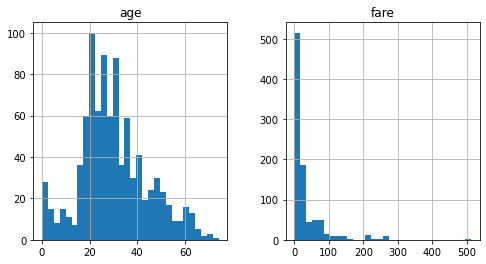

In [6]:
X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal frequency discretisation with Feature-Engine

**Set up the equal frequency discretiser to encode variables we need them returned as objects for feature-engine!**

In [7]:
disc = EqualFrequencyDiscretiser(
    q=10, variables=['age', 'fare'], return_object=True)
disc.fit(X_train)  # find the intervals
train_t = disc.transform(X_train)  # transform train and text
test_t = disc.transform(X_test)

In [8]:
train_t.dtypes

age     object
fare    object
dtype: object

In [9]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,7,1
686,2,1


**Explore if the bins have a linear relationship with the target:**

Text(0, 0.5, 'mean of survived')

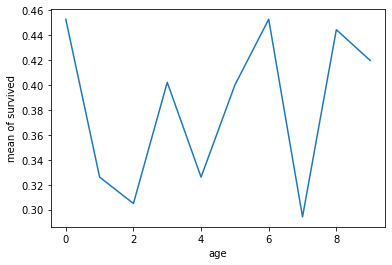

In [10]:
pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel('mean of survived')

Text(0, 0.5, 'mean of survived')

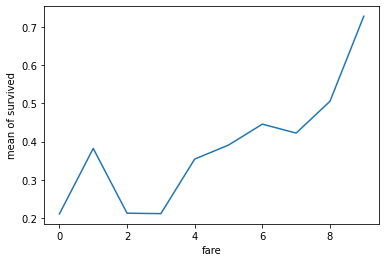

In [11]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel('mean of survived')

None of the variables show a monotonic relationship between the intervals of the discrete variable and the mean of survival. We can encode the intervals to return a monotonic relationship:

# Ordinal encoding with Feature-Engine

In [12]:
enc = OrdinalEncoder(encoding_method = 'ordered')
enc.fit(train_t, y_train)
train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

**In the map, map bin to position!**

In [13]:
enc.encoder_dict_

{'age': {7: 0, 2: 1, 1: 2, 4: 3, 5: 4, 3: 5, 9: 6, 8: 7, 0: 8, 6: 9},
 'fare': {0: 0, 3: 1, 2: 2, 4: 3, 1: 4, 5: 5, 7: 6, 6: 7, 8: 8, 9: 9}}

Text(0, 0.5, 'mean of survived')

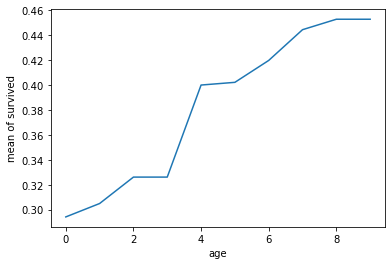

In [14]:
pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel('mean of survived')

Text(0, 0.5, 'mean of survived')

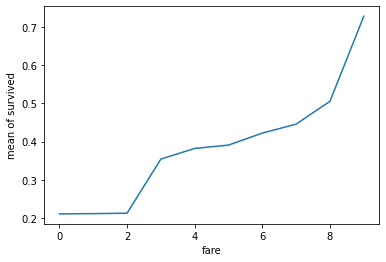

In [15]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel('mean of survived')

Now we obtained a monotonic relationship between variables and target.